# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from scipy.signal import medfilt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load CSVs

In [5]:
def clean_csv(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    # Step 1: Drop unnecessary columns
    columns_to_drop = ['raw', 'ExperimentTime', 'analysis/ch3_seg_body', 'analysis/ch3_seg_body_str']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    if 'point_of_death' in df.columns:
        # Propagate 'point_of_death' within each 'Point' group
        df['point_of_death'] = df.groupby('Point')['point_of_death'].transform(lambda x: x.ffill().bfill())

    # Replace NaNs in 'stardist_eggs' column with 0
    df['stardist_eggs'].fillna(0, inplace=True)
    df['csrnet_eggs'].fillna(0, inplace=True)
    
    # Convert 'stardist_eggs' and 'csrnet_eggs' columns to integers
    df['stardist_eggs'] = df['stardist_eggs'].astype(int)
    df['csrnet_eggs'] = df['csrnet_eggs'].astype(int)

    # Step 2: Identify Points to be dropped (where M4 is empty)
    points_dropped = df[df['M4'].isna()]['Point'].unique()
    
    # Step 3: Drop rows where M4 is empty
    df = df[df['M4'].notna()]
    

    # Print the Points that have been dropped
    if len(points_dropped) > 0:
        print(f"Dropped Points due to empty M4: {', '.join(map(str, points_dropped))}")
    else:
        print("No Points were dropped.")

    return df, list(points_dropped)




In [ ]:
def load_and_merge_csvs(file_paths, bacteria_lists, breakpoint_lists):
    df_full = pd.DataFrame()
    dropped_points = list()

    for i, (file_path, bacteria, breakpoints) in enumerate(zip(file_paths, bacteria_lists, breakpoint_lists), start = 1):
         
        df = pd.read_csv(file_path)
        df['Point'] = df['Point'] + (i / 10)
        df, dropped = clean_csv(df)
        df = sync_time(df)
        df = assign_bacteria(df, bacteria, breakpoints)

        df_full = pd.concat([df_full, df], axis = 0)
        dropped_points.append(dropped)
    
    df_full = df_full.reset_index(drop=True)
    dropped_points = list(itertools.chain(*dropped_points))

    

    return df_full, dropped_points
    


# Overall Plots

In [6]:
def overall_plots(df):
    # Check necessary columns
    required_columns = ['Time', 'ch3_seg_body_str_volume', 'ch3_seg_body_str_length', 
                        'ch3_seg_body_str_area', 'csrnet_eggs', 'stardist_eggs']
    for column in required_columns:
        if column not in df.columns:
            raise ValueError(f"The column '{column}' is missing from the DataFrame.")

    # Step 1: Group by Time and calculate averages and standard deviations
    volume_growth = df.groupby('Time')['ch3_seg_body_str_volume'].agg(['mean', 'std', 'count']).reset_index()
    length_growth = df.groupby('Time')['ch3_seg_body_str_length'].agg(['mean', 'std', 'count']).reset_index()
    area_growth = df.groupby('Time')['ch3_seg_body_str_area'].agg(['mean', 'std', 'count']).reset_index()
    egg_counts = df.groupby('Time')[['csrnet_eggs', 'stardist_eggs']].agg(['mean', 'std', 'count']).reset_index()

    # Step 2: Calculate confidence intervals for volume, length, and area
    for growth in [volume_growth, length_growth, area_growth]:
        growth['ci_lower'] = growth['mean'] - 1.96 * (growth['std'] / np.sqrt(growth['count']))
        growth['ci_upper'] = growth['mean'] + 1.96 * (growth['std'] / np.sqrt(growth['count']))

    # Step 3: Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))

    # Subplot 1: Average Volume, Length, and Area
    axs[0].plot(volume_growth['Time'], volume_growth['mean'], label='Volume', color='blue')  # Volume
    axs[0].fill_between(volume_growth['Time'], volume_growth['ci_lower'], volume_growth['ci_upper'], 
                        color='blue', alpha=0.2)

    axs[0].plot(length_growth['Time'], length_growth['mean'], label='Length', color='green')  # Length
    axs[0].fill_between(length_growth['Time'], length_growth['ci_lower'], length_growth['ci_upper'], 
                        color='green', alpha=0.2)

    axs[0].plot(area_growth['Time'], area_growth['mean'], label='Area', color='orange')  # Area
    axs[0].fill_between(area_growth['Time'], area_growth['ci_lower'], area_growth['ci_upper'], 
                        color='orange', alpha=0.2)

    axs[0].set_xticks(volume_growth['Time'][::50])  # Set x-axis ticks
    axs[0].set_yscale('log')  # Logarithmic scale for y-axis
    axs[0].set_title('Average Growth Measurements Over Time')
    axs[0].set_xlabel('Time [hours]')
    axs[0].set_ylabel('Size (Log Scale) [micrometers]')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Average Egg Counts
    axs[1].plot(egg_counts['Time'], egg_counts['csrnet_eggs']['mean'], label='CSRNet', color='purple')
    axs[1].fill_between(egg_counts['Time'], 
                        egg_counts['csrnet_eggs']['mean'] - 1.96 * (egg_counts['csrnet_eggs']['std'] / np.sqrt(egg_counts['csrnet_eggs']['count'])),
                        egg_counts['csrnet_eggs']['mean'] + 1.96 * (egg_counts['csrnet_eggs']['std'] / np.sqrt(egg_counts['csrnet_eggs']['count'])),
                        color='purple', alpha=0.2)

    axs[1].plot(egg_counts['Time'], egg_counts['stardist_eggs']['mean'], label='StarDist', color='red')
    axs[1].fill_between(egg_counts['Time'], 
                        egg_counts['stardist_eggs']['mean'] - 1.96 * (egg_counts['stardist_eggs']['std'] / np.sqrt(egg_counts['stardist_eggs']['count'])),
                        egg_counts['stardist_eggs']['mean'] + 1.96 * (egg_counts['stardist_eggs']['std'] / np.sqrt(egg_counts['stardist_eggs']['count'])),
                        color='red', alpha=0.2)

    axs[1].set_xticks(egg_counts['Time'][::50])  # Set x-axis ticks
    axs[1].set_title('Average Egg Counts Over Time')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Average Egg Counts')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Synchronise Time and assign bacteria category

In [7]:
def sync_time(df):
    df['Time_synced'] = df['Time'] - df['M4']
    return df

def assign_bacteria(df, mutation_names, breaking_points):
    # Ensure breaking points cover all mutation names, even for the last range
    if len(mutation_names) > len(breaking_points):
        breaking_points.append(df['Point'].max() + 1)  # Add a high value to cover all remaining points

    # Initialize the 'mutation' column
    df['bacteria'] = None
    df['bacteria_dummies'] = None

    # Assign mutation names based on breaking points without re-sorting
    current_index = 0
    for name, breakpoint in zip(mutation_names, breaking_points):
        mask = (df['Point'] >= current_index) & (df['Point'] < breakpoint)
        df.loc[mask, 'bacteria'] = name
        if name == 'EV':
            df.loc[mask, 'bacteria_dummies'] = 0
        elif name == 'mex3':
            df.loc[mask, 'bacteria_dummies'] = 1
        else:
            print("Name cannot be translated to dummies")
            df['bacteria_dummies'] = df['bacteria']
        current_index = breakpoint

    return df


# Smooth Measurement

In [ ]:
def smooth_measurement(df, column_names, kernel_size=3):
    """
    Apply median filtering to smooth growth measurements over time for each worm (Point).

    Parameters:
    df (pd.DataFrame): DataFrame containing growth measurements.
    column_names (list): List of column names for growth measurements to be smoothed.
    kernel_size (int): Size of the median filter kernel (should be an odd number).

    Returns:
    pd.DataFrame: DataFrame with additional columns for smoothed growth measurements.
    """
    # Ensure the kernel size is valid
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size should be an odd number.")

    # Create a copy of the DataFrame to avoid modifying the original
    smoothed_df = df.copy()

    # Smooth each specified column
    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in DataFrame.")

                # Create a new column for the smoothed values
        smoothed_values = pd.Series(index=df.index)  # Initialize with NaN

        # Group by 'Point'
        for point, group in df.groupby('Point'):
            # Ensure the group is sorted by 'Time' for smoothing
            group_sorted = group.sort_values(by='Time')

            # Apply median filtering to the specific column
            smoothed_group_values = medfilt(group_sorted[column_name].values, kernel_size=kernel_size)

            # Map smoothed values back to their original indices
            smoothed_values.loc[group_sorted.index] = smoothed_group_values

        # Assign the smoothed values to the new column in the copy DataFrame
        smoothed_df[f'smoothed_{column_name}'] = smoothed_values

    return smoothed_df




# Get linear data regression for metrics

In [17]:
def get_data_regression(df):    
    # Identify egg columns
    egg_columns = [col for col in df.columns if '_eggs' in col]
    
    # Identify points to remove based on max egg count condition
    points_to_remove = []

    # Iterate over each 'Point' and check if the maximum egg count in any of the egg columns is below 10
    for point, group in df.groupby('Point'):
        # Check the maximum egg count for each egg column in the group
        max_egg_counts = group[egg_columns].max()

        # If any of the egg columns have a max count < 10, mark this point for removal
        if (max_egg_counts < 10).any():
            points_to_remove.append(point)

    # Print points that are removed
    print(f"Points removed due to having max egg count < 10 in any column: {points_to_remove}")

    # Filter the DataFrame to remove the identified points
    df_filtered = df[~df['Point'].isin(points_to_remove)]
    

    def fetch_data_regression(group):
        regressions = {
            'Point': group['Point'].iloc[0],
            'bacteria': group['bacteria'].iloc[0],
            'bacteria_dummies': group['bacteria_dummies'].iloc[0]
        }  # Initialize with the group key
        
        for column in group.columns:
            min_time = None
            max_time = None
            feature_data = None
            intercept_real = None

            if '_eggs' in column:
                time_init_min_point = group.loc[(group[column] == group[column].min()) & (group['Time_synced'] < 40), 'Time_synced'].min()
                min_time = group.loc[(group[column] >= 10) & (group['Time_synced'] >= time_init_min_point), 'Time_synced'].min() - 2
                max_time = group.loc[(group[column] == group[column].max()) & (group['Time_synced'] >= 40), 'Time_synced'].min()
                dif_time = max_time - min_time
                if dif_time > 20:
                    max_time = min_time + 20

            if '_seg_body_str' in column and '_at_' not in column:
                min_time = 0
                max_time = 40
                            
                if 'area' in column or 'volume' in column:
                    # Log-transform the values before regression
                    group[column] = np.log(group[column] + 1e-5)  # Add a small constant to avoid log(0)
       
            if min_time is not None and max_time is not None:
                feature_data = group[(group['Time_synced'] >= min_time) & (group['Time_synced'] <= max_time)][['Time_synced', column]]
                feature_data = feature_data.dropna(subset=[column])
                intercept_real = float(group.loc[group['Time_synced'] >= min_time, column].iloc[0])

            # Only proceed if there's data in the time range
            if feature_data is not None: 
                if not feature_data.empty:
                    X = feature_data['Time_synced'].values.reshape(-1, 1)
                    y = feature_data[column].values
                    
                    # Perform linear regression
                    model = LinearRegression().fit(X, y)
                    regressions.update({
                        f'{column}_times': (min_time, max_time),
                        f'{column}_slope': model.coef_[0],
                        f'{column}_intercept_model': model.intercept_,
                        f'{column}_intercept_real': intercept_real,
                        f'{column}_r_squared': model.score(X, y)
                    })

        return pd.DataFrame([regressions])


    regression_df = df_filtered.groupby('Point', as_index=False).apply(fetch_data_regression).reset_index(drop=True)

    # Filter columns ending with '_slope'
    slope_columns = regression_df.filter(regex=r'_slope$').columns
    egg_columns = ['smoothed_csrnet_eggs_slope', 'csrnet_eggs_slope']

    # Identify rows where all '_slope' columns have non-negative values
    valid_points = regression_df.loc[(regression_df[slope_columns] >= 0).all(axis=1), 'Point']

    # Identify points to remove: rows where any '_slope' column has a negative value
    removed_points = regression_df.loc[~regression_df['Point'].isin(valid_points), 'Point']
    regression_df = regression_df[~regression_df['Point'].isin(removed_points)]
    df_filtered = df_filtered[~df_filtered['Point'].isin(removed_points)]
    points_removed = points_to_remove.append(removed_points)
    # Identify rows where all '_slope' columns have non-negative values
    valid_points = regression_df.loc[(regression_df[egg_columns] <= 6).all(axis=1), 'Point']

    # Identify points to remove: rows where any '_slope' column has a negative value
    removed_points = regression_df.loc[~regression_df['Point'].isin(valid_points), 'Point']
    regression_df = regression_df[~regression_df['Point'].isin(removed_points)]
    df_filtered = df_filtered[~df_filtered['Point'].isin(removed_points)]
    points_removed = points_to_remove.append(removed_points)
    print(f"Points removed: {points_removed}.")
    
    return regression_df, df_filtered, points_removed




# Find best multiple regression model

In [11]:
def find_best_model(regression_df):
    # Define strings for smooth vs non-smooth and for the reproduction and growth metrics
    str_list_1 = ['smoothed_', '']
    str_list_2 = ['csrnet', 'stardist']
    str_list_3 = ['area', 'volume']

    # To track the best model
    best_model_info = {
        'combination': None,
        'model_type': None,
        'r_squared': -np.inf,  # Starting with negative infinity for maximization
        'rmse': np.inf,  # Starting with positive infinity for minimization
        'combined_df': None
    }

    # Loop through each combination of smooth/non-smooth, reproduction method, and growth metric
    for str1 in str_list_1:
        for str2 in str_list_2:
            reproduction_str = str1 + str2 + '_eggs'
            
            for str3 in str_list_3:
                growth_str = str1 + 'ch3_seg_body_str_' + str3
                
                # Prepare combined DataFrame for analysis
                combined_df = pd.DataFrame({
                    'Point': regression_df['Point'],
                    'bacteria': regression_df['bacteria'],
                    'bacteria_dummies': regression_df['bacteria_dummies'],
                    'reproduction_rate': regression_df[reproduction_str + '_slope'],
                    'growth_rate': regression_df[growth_str + '_slope'],
                    'size_at_sync_model': regression_df[growth_str + '_intercept_model'],
                    'size_at_sync_real': regression_df[growth_str + '_intercept_real'],
                    'eggs_at_sync_model': regression_df[reproduction_str + '_intercept_model'],
                    'eggs_at_sync_real': regression_df[reproduction_str + '_intercept_real'],
                    
                })
                
                
                combined_df = combined_df.dropna()
                

                # Define X and y
                X = combined_df.drop(['growth_rate', 'Point', 'bacteria','size_at_sync_model', 'size_at_sync_real'], axis=1)
                y = combined_df['growth_rate']

                # Train-test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

                ### Multiple Linear Regression
                # Initialize the model
                mlr_model = LinearRegression()

                # Fit the model on the training data
                mlr_model.fit(X_train, y_train)

                # Predict on the test data
                mlr_pred = mlr_model.predict(X_test)

                # Evaluate the model
                mlr_rmse = mean_squared_error(y_test, mlr_pred, squared=False)
                mlr_r2 = r2_score(y_test, mlr_pred)


                ### Random Forest Regressor
                rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
                rf_model.fit(X_train, y_train)
                rf_predictions = rf_model.predict(X_test)

                # Evaluate Random Forest
                rf_r2 = r2_score(y_test, rf_predictions)
                rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

                ### Gradient Boosting Regressor
                gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
                gb_model.fit(X_train, y_train)
                gb_predictions = gb_model.predict(X_test)

                # Evaluate Gradient Boosting
                gb_r2 = r2_score(y_test, gb_predictions)
                gb_rmse = mean_squared_error(y_test, gb_predictions, squared=False)

                en_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
                en_model.fit(X_train, y_train)
                en_predictions = en_model.predict(X_test)

                # Evaluate ElasticNet
                en_r2 = r2_score(y_test, en_predictions)
                en_rmse = mean_squared_error(y_test, en_predictions, squared=False)
                

                # Print results for the current combination
                print(f'Combination: {str1} | {str2} | {str3}')
                print("Multiple Linear Regression:")
                print(f"  R-squared: {mlr_r2:.3f}, RMSE: {mlr_rmse:.3f}")
                print("Random Forest:")
                print(f"  R-squared: {rf_r2:.3f}, RMSE: {rf_rmse:.3f}")
                print("Gradient Boosting:")
                print(f"  R-squared: {gb_r2:.3f}, RMSE: {gb_rmse:.3f}")
                print("Support Vector Regression:")
                print(f"  R-squared: {en_r2:.3f}, RMSE: {en_rmse:.3f}")
                print("-" * 50)

                # Check for the best model based on R-squared or RMSE
                for model_type, r2, rmse in [
                    ('Multiple Linear Regression', mlr_r2, mlr_rmse),
                    ('Random Forest', rf_r2, rf_rmse),
                    ('Gradient Boosting', gb_r2, gb_rmse),
                    ('ElasticNet', en_r2, en_rmse),
                ]:
                    if r2 > best_model_info['r_squared']:
                        best_model_info['combination'] = f"{str1} | {str2} | {str3}"
                        best_model_info['model_type'] = model_type
                        best_model_info['r_squared'] = r2
                        best_model_info['rmse'] = rmse
                        best_model_info['combined_df'] = combined_df

    # Print the best model summary
    print("\nBest Model Summary:")
    print(f"Combination: {best_model_info['combination']}")
    print(f"Model Type: {best_model_info['model_type']}")
    print(f"R-squared: {best_model_info['r_squared']:.3f}")
    print(f"RMSE: {best_model_info['rmse']:.3f}")

    return best_model_info




# Get Feature Importance

In [ ]:
def get_feature_importance(best_model_info):
    
    combined_df = best_model_info['combined_df']
    model_type = best_model_info['model_type']
    
    # Define X and y
    X = combined_df.drop(['growth_rate', 'Point', 'bacteria', 'size_at_sync_real', 'size_at_sync_model','eggs_at_sync_model'], axis=1)
    y = combined_df['growth_rate']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if model_type == 'Multiple Linear Regression':
        model = LinearRegression()

        model.fit(X_train, y_train)
        importances = model.coef_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    if model_type == 'Random Forest':
        ### Random Forest Regressor
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        model.fit(X_train, y_train)
        
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

    elif model_type == 'Gradient Boosting':
        ### Gradient Boosting Regressor
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        
        model.fit(X_train, y_train)
        
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
        
    elif model_type == 'ElasticNet':
        model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
        
        model.fit(X_train, y_train)
        
        importances = model.coef_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()



    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Calculate VIF for each feature
    X_with_const = sm.add_constant(X_train)
    X_with_const['bacteria_dummies'] = X_with_const['bacteria_dummies'].explode().astype(int)



    # Add constant for VIF calculation
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    # Filter out the constant feature
    vif_data = vif_data[vif_data["Feature"] != "const"]

    corr_df = combined_df.drop(['Point', 'bacteria'], axis=1)

    correlation_matrix = corr_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

    # Perform K-Fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = (-cv_scores)**0.5

    print(f'Cross-Validation RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}')


#Multiple Linear Regression --- 
#LASSO or RIDGE






# Compare bacteria categories

In [ ]:
def get_bacteria_comparison(combined_df):
    # Define custom color palettes
    red_palette = sns.color_palette(["#FF9999", "#CC0000"])  # Lighter and darker red shades
    blue_palette = sns.color_palette(["#99CCFF", "#003366"])  # Lighter and darker blue shades

    # Set the aesthetics for the plots
    sns.set(style="whitegrid")

    # Create violin plots for each variable, separated by bacteria type
    plt.figure(figsize=(12, 6))

    # Plot reproduction_rate with two shades of red
    plt.subplot(1, 2, 1)
    sns.violinplot(
        data=combined_df,
        x='bacteria',
        y='reproduction_rate',
        palette=red_palette
    )
    plt.title('Reproduction Rate by Bacteria')
    plt.xticks(rotation=45)

    # Plot growth_rate with two shades of blue
    plt.subplot(1, 2, 2)
    sns.violinplot(
        data=combined_df,
        x='bacteria',
        y='growth_rate',
        palette=blue_palette
    )
    plt.title('Growth Rate by Bacteria')
    plt.xticks(rotation=45)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.suptitle('Violin Plots of Regression Variables by Bacteria Type', y=1.02)
    plt.show()

# Example usage
get_bacteria_comparison(combined_df)

In [ ]:
def plot_avg_egg_counts(df):
    # Filter for EV and mex3 worms (assuming 'bacteria' column exists)
    df_ev_mex3 = df[df['bacteria'].isin(['EV', 'mex3'])]

    # Define the egg count columns (you might need to adjust this based on your column names)
    egg_columns = [col for col in df_ev_mex3.columns if '_eggs' in col]

    # Initialize the figure and subplots
    num_columns = len(egg_columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 6 * num_columns), sharex=True)

    # Loop over egg columns to plot for each
    for ax, egg_column in zip(axes, egg_columns):
        # Group by bacteria and Time, then calculate the mean and standard error
        egg_counts_avg = df_ev_mex3.groupby(['bacteria', 'Time_synced'])[egg_column].mean().reset_index()
        egg_counts_std = df_ev_mex3.groupby(['bacteria', 'Time_synced'])[egg_column].std().reset_index()

        # Merge the mean and std error dataframes
        egg_counts = pd.merge(egg_counts_avg, egg_counts_std, on=['bacteria', 'Time_synced'], suffixes=('_mean', '_std'))

        # Plot the data
        for bacteria in ['EV', 'mex3']:
            subset = egg_counts[egg_counts['bacteria'] == bacteria]
            # Assign a color to each bacteria
            line_color = 'blue' if bacteria == 'EV' else 'red'  # You can adjust the colors as needed
            
            # Plot the mean line
            ax.plot(subset['Time_synced'], subset[f'{egg_column}_mean'], label=f'{bacteria} - {egg_column}', lw=2, color=line_color)

            # Plot the std error as a semi-transparent surface
            ax.fill_between(subset['Time_synced'], 
                            subset[f'{egg_column}_mean'] - subset[f'{egg_column}_std'], 
                            subset[f'{egg_column}_mean'] + subset[f'{egg_column}_std'], 
                            color=line_color, alpha=0.3)  # Same color as the line

        # Customize the subplot
        ax.set_title(f'Average Egg Counts for {egg_column}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Egg Count')
        ax.grid(True)
        ax.legend(loc='upper left')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Usage
# Assuming df_full is your merged dataframe
plot_avg_egg_counts(df)


NameError: name 'df' is not defined

# MAIN FUNCTION

/tmp/ipykernel_1887141/4028904181.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['stardist_eggs'].fillna(0, inplace=True)
/tmp/ipykernel_1887141/4028904181.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Dropped Points due to empty M4: 0.1, 1.1, 2.1, 3.1, 4.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 14.1, 15.1, 16.1, 17.1, 18.1, 23.1, 24.1, 35.1, 36.1, 37.1, 38.1, 39.1, 40.1, 41.1, 42.1, 43.1, 45.1, 46.1, 48.1, 49.1, 50.1, 51.1, 52.1, 53.1, 54.1, 55.1, 56.1, 57.1, 58.1, 59.1, 60.1, 61.1, 62.1, 63.1, 64.1, 65.1, 66.1, 67.1, 68.1, 69.1, 70.1, 71.1, 72.1, 73.1, 74.1, 75.1, 76.1, 77.1, 78.1, 80.1, 81.1, 82.1, 83.1, 85.1, 86.1, 87.1, 88.1, 89.1, 90.1, 91.1, 92.1, 93.1, 94.1, 95.1, 96.1, 97.1, 102.1, 104.1, 105.1, 109.1, 111.1, 115.1, 116.1, 121.1, 122.1, 127.1, 129.1, 130.1, 134.1, 135.1, 136.1, 137.1, 138.1, 139.1, 140.1


/tmp/ipykernel_1887141/4028904181.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['stardist_eggs'].fillna(0, inplace=True)
/tmp/ipykernel_1887141/4028904181.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Dropped Points due to empty M4: 0.2, 2.2, 3.2, 5.2, 8.2, 11.2, 12.2, 15.2, 16.2, 17.2, 18.2, 19.2, 21.2, 22.2, 27.2, 29.2, 33.2, 36.2, 39.2, 41.2, 42.2, 45.2, 46.2, 56.2, 62.2, 63.2, 64.2, 65.2, 66.2, 67.2, 71.2, 72.2, 73.2, 74.2, 75.2, 80.2, 82.2, 83.2, 84.2, 86.2, 88.2, 92.2, 93.2, 97.2, 99.2, 102.2, 106.2, 108.2, 109.2, 112.2, 114.2, 116.2, 120.2, 122.2, 123.2, 125.2, 131.2, 137.2, 138.2, 141.2, 142.2, 150.2, 151.2, 152.2, 153.2, 154.2, 156.2, 157.2, 158.2, 161.2, 162.2, 163.2, 164.2, 172.2, 173.2, 174.2, 179.2, 180.2, 181.2, 186.2, 187.2, 191.2, 194.2, 195.2, 197.2, 200.2, 202.2, 203.2, 204.2, 208.2, 209.2, 211.2, 212.2, 213.2, 216.2, 218.2, 219.2, 220.2, 221.2, 222.2, 224.2, 225.2, 226.2, 227.2, 228.2, 229.2, 231.2, 233.2


/tmp/ipykernel_1887141/4028904181.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['stardist_eggs'].fillna(0, inplace=True)
/tmp/ipykernel_1887141/4028904181.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Dropped Points due to empty M4: 0.3, 1.3, 2.3, 3.3, 4.3, 5.3, 6.3, 7.3, 9.3, 16.3, 18.3, 22.3, 24.3, 26.3, 30.3, 31.3, 32.3, 33.3, 34.3, 35.3, 36.3, 37.3, 38.3, 39.3, 40.3, 41.3, 42.3, 43.3, 44.3, 45.3, 46.3, 47.3, 48.3, 49.3, 50.3, 54.3, 59.3, 60.3, 61.3, 62.3, 63.3, 65.3, 66.3, 67.3, 70.3, 71.3, 72.3, 74.3, 75.3, 76.3, 77.3, 78.3, 79.3, 80.3, 81.3, 82.3, 83.3, 84.3, 85.3, 86.3, 87.3, 88.3, 89.3, 90.3, 91.3, 92.3, 93.3, 94.3, 95.3, 96.3, 97.3, 98.3, 99.3, 100.3, 110.3, 112.3, 114.3, 115.3, 117.3, 118.3, 119.3, 120.3, 121.3, 122.3, 123.3, 124.3, 125.3, 126.3, 127.3, 128.3, 129.3, 130.3, 131.3, 132.3, 133.3, 134.3, 135.3, 136.3, 137.3, 138.3, 139.3, 140.3
[0.1, 1.1, 2.1, 3.1, 4.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 14.1, 15.1, 16.1, 17.1, 18.1, 23.1, 24.1, 35.1, 36.1, 37.1, 38.1, 39.1, 40.1, 41.1, 42.1, 43.1, 45.1, 46.1, 48.1, 49.1, 50.1, 51.1, 52.1, 53.1, 54.1, 55.1, 56.1, 57.1, 58.1, 59.1, 60.1, 61.1, 62.1, 63.1, 64.1, 65.1, 66.1, 67.1, 68.1, 69.1, 70.1, 71.1, 72.1, 73.1, 74.1, 75

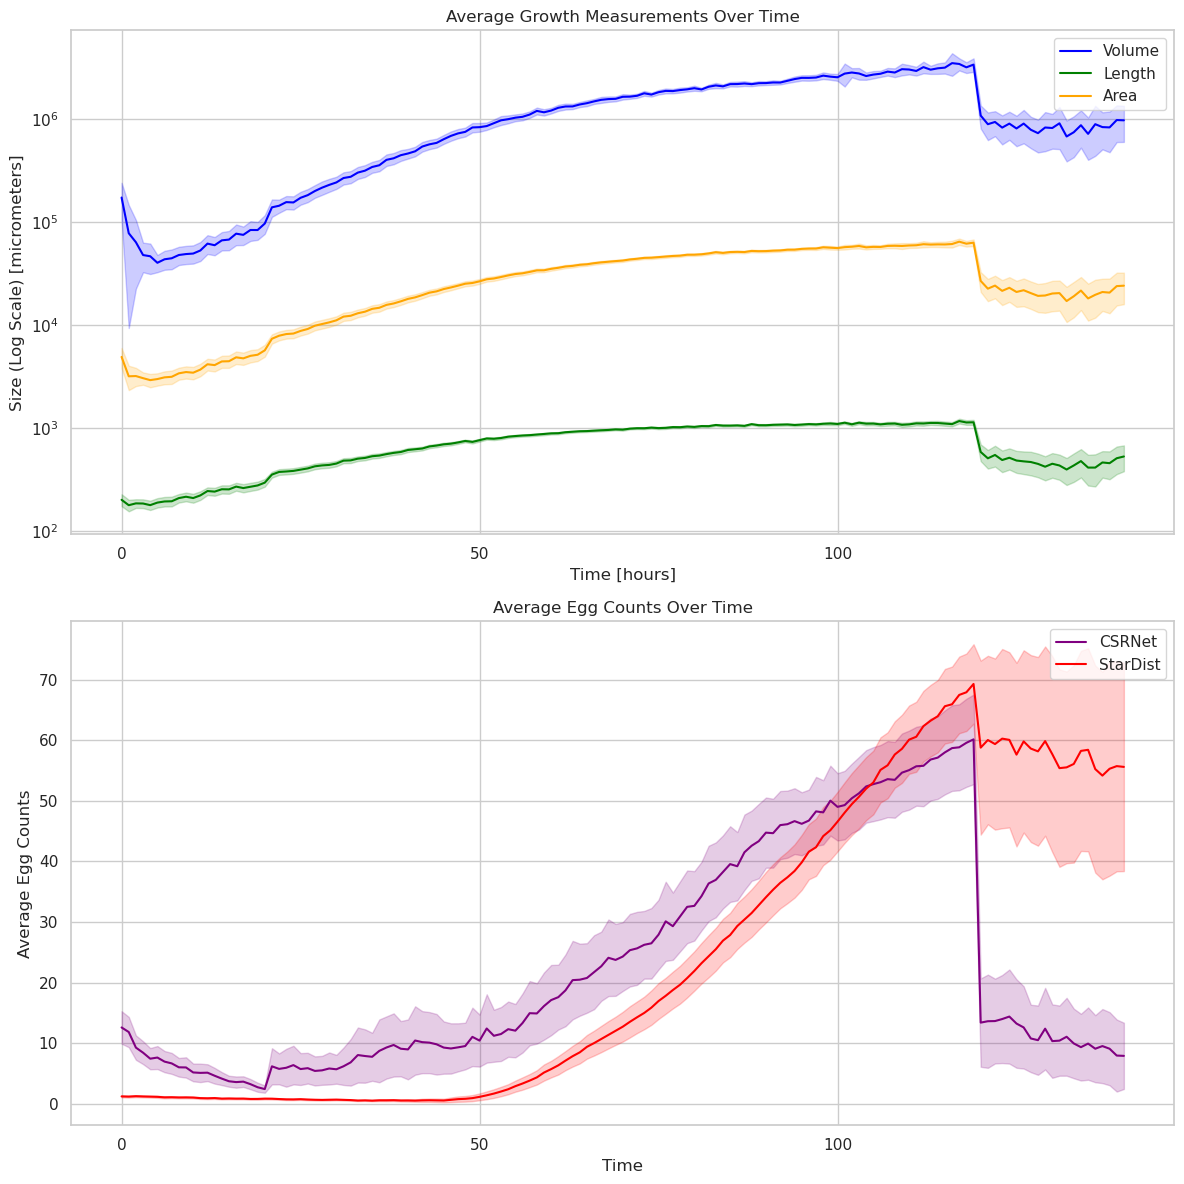

Points removed due to having max egg count < 10 in any column: [53.3, 89.2, 104.3, 106.3, 115.2, 148.2, 199.2]


/tmp/ipykernel_1887141/2442694732.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regression_df = df_filtered.groupby('Point', as_index=False).apply(fetch_data_regression).reset_index(drop=True)
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean sq

Points removed: None.
[0.1, 1.1, 2.1, 3.1, 4.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 14.1, 15.1, 16.1, 17.1, 18.1, 23.1, 24.1, 35.1, 36.1, 37.1, 38.1, 39.1, 40.1, 41.1, 42.1, 43.1, 45.1, 46.1, 48.1, 49.1, 50.1, 51.1, 52.1, 53.1, 54.1, 55.1, 56.1, 57.1, 58.1, 59.1, 60.1, 61.1, 62.1, 63.1, 64.1, 65.1, 66.1, 67.1, 68.1, 69.1, 70.1, 71.1, 72.1, 73.1, 74.1, 75.1, 76.1, 77.1, 78.1, 80.1, 81.1, 82.1, 83.1, 85.1, 86.1, 87.1, 88.1, 89.1, 90.1, 91.1, 92.1, 93.1, 94.1, 95.1, 96.1, 97.1, 102.1, 104.1, 105.1, 109.1, 111.1, 115.1, 116.1, 121.1, 122.1, 127.1, 129.1, 130.1, 134.1, 135.1, 136.1, 137.1, 138.1, 139.1, 140.1, 0.2, 2.2, 3.2, 5.2, 8.2, 11.2, 12.2, 15.2, 16.2, 17.2, 18.2, 19.2, 21.2, 22.2, 27.2, 29.2, 33.2, 36.2, 39.2, 41.2, 42.2, 45.2, 46.2, 56.2, 62.2, 63.2, 64.2, 65.2, 66.2, 67.2, 71.2, 72.2, 73.2, 74.2, 75.2, 80.2, 82.2, 83.2, 84.2, 86.2, 88.2, 92.2, 93.2, 97.2, 99.2, 102.2, 106.2, 108.2, 109.2, 112.2, 114.2, 116.2, 120.2, 122.2, 123.2, 125.2, 131.2, 137.2, 138.2, 141.2, 142.2, 150.2, 

/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination: smoothed_ | csrnet | area
Multiple Linear Regression:
  R-squared: 0.358, RMSE: 0.005
Random Forest:
  R-squared: 0.071, RMSE: 0.006
Gradient Boosting:
  R-squared: -0.002, RMSE: 0.007
Support Vector Regression:
  R-squared: -0.003, RMSE: 0.007
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination: smoothed_ | csrnet | volume
Multiple Linear Regression:
  R-squared: 0.358, RMSE: 0.009
Random Forest:
  R-squared: 0.029, RMSE: 0.011
Gradient Boosting:
  R-squared: -0.444, RMSE: 0.013
Support Vector Regression:
  R-squared: -0.004, RMSE: 0.011
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination: smoothed_ | stardist | area
Multiple Linear Regression:
  R-squared: 0.318, RMSE: 0.006
Random Forest:
  R-squared: 0.428, RMSE: 0.005
Gradient Boosting:
  R-squared: 0.419, RMSE: 0.005
Support Vector Regression:
  R-squared: -0.003, RMSE: 0.007
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination: smoothed_ | stardist | volume
Multiple Linear Regression:
  R-squared: 0.313, RMSE: 0.009
Random Forest:
  R-squared: 0.462, RMSE: 0.008
Gradient Boosting:
  R-squared: 0.473, RMSE: 0.008
Support Vector Regression:
  R-squared: -0.004, RMSE: 0.011
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination:  | csrnet | area
Multiple Linear Regression:
  R-squared: -0.054, RMSE: 0.006
Random Forest:
  R-squared: -0.148, RMSE: 0.007
Gradient Boosting:
  R-squared: -0.274, RMSE: 0.007
Support Vector Regression:
  R-squared: -0.000, RMSE: 0.006
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination:  | csrnet | volume
Multiple Linear Regression:
  R-squared: -0.028, RMSE: 0.008
Random Forest:
  R-squared: -0.183, RMSE: 0.009
Gradient Boosting:
  R-squared: -0.479, RMSE: 0.010
Support Vector Regression:
  R-squared: -0.022, RMSE: 0.008
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

Combination:  | stardist | area
Multiple Linear Regression:
  R-squared: -0.079, RMSE: 0.006
Random Forest:
  R-squared: 0.024, RMSE: 0.006
Gradient Boosting:
  R-squared: -0.412, RMSE: 0.007
Support Vector Regression:
  R-squared: -0.000, RMSE: 0.006
--------------------------------------------------


/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smarin/micromamba/envs/towbintools/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Combination:  | stardist | volume
Multiple Linear Regression:
  R-squared: -0.253, RMSE: 0.009
Random Forest:
  R-squared: -0.244, RMSE: 0.009
Gradient Boosting:
  R-squared: -0.515, RMSE: 0.010
Support Vector Regression:
  R-squared: -0.022, RMSE: 0.008
--------------------------------------------------

Best Model Summary:
Combination: smoothed_ | stardist | volume
Model Type: Gradient Boosting
R-squared: 0.473
RMSE: 0.008


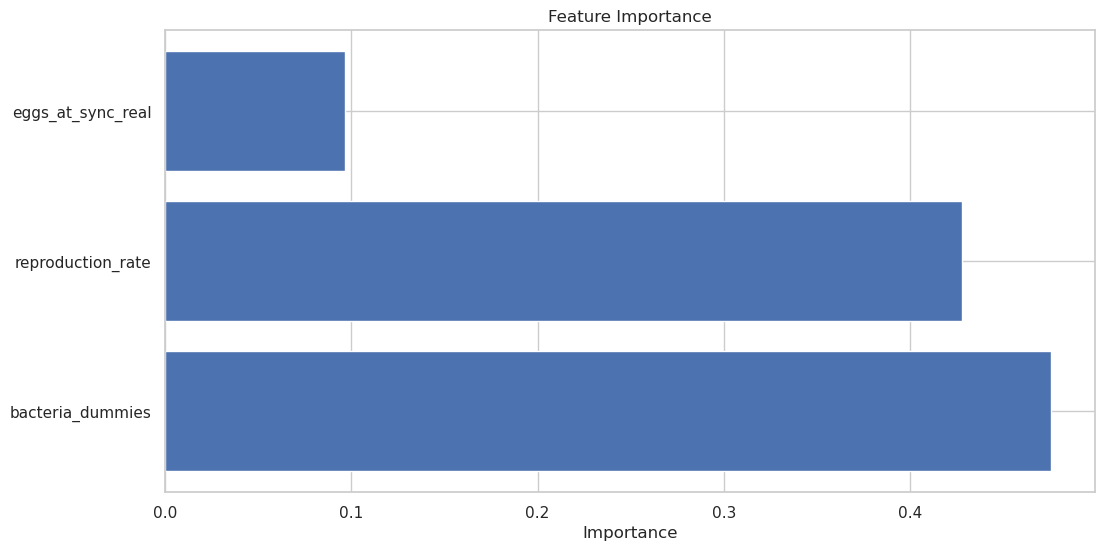

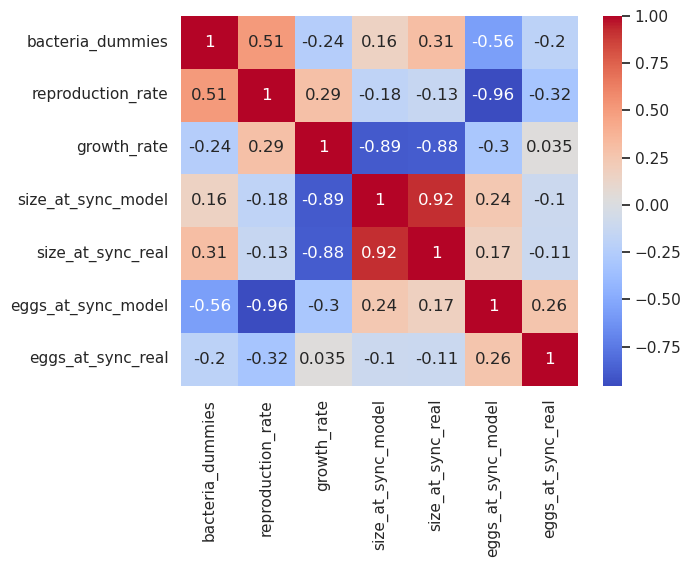

Cross-Validation RMSE: 0.009054638293461256 ± 0.0016398541011688479


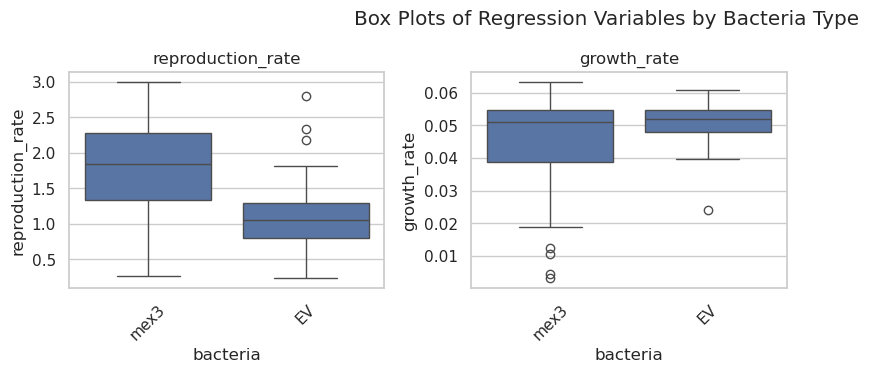

In [18]:
def main(file_paths, bacteria_lists, breakpoint_lists):
    df, dropped = load_and_merge_csvs(file_paths, bacteria_lists, breakpoint_lists)
    print(dropped)
    overall_plots(df)
    df_smoothed = smooth_measurement(df, ['ch3_seg_body_str_length', 'ch3_seg_body_str_area', 'ch3_seg_body_str_volume', 'stardist_eggs', 'csrnet_eggs'], kernel_size = 25)
    regression_df, df_filtered, points_removed = get_data_regression(df_smoothed)
    dropped.append(points_removed)
    print(dropped)
    best_model_info = find_best_model(regression_df)
    get_feature_importance(best_model_info)
    combined_df = best_model_info['combined_df']
    combined_df['bacteria'] = pd.Series(combined_df['bacteria'], dtype=pd.StringDtype())
    get_bacteria_comparison(combined_df)
    return df_filtered, regression_df, combined_df, dropped



file_path1 = '/mnt/towbin.data/shared/smarin/analysis/20241308_squid_wbt_318_ev_mex_3/analysis/report/analysis_filemap_merged_annotated_v8.csv'
file_path2 = '/mnt/towbin.data/shared/smarin/analysis/20241707_souvik_w318_ev_mex3_squid/analysis/report/analysis_filemap_merged3_annotated.csv'
file_path3 = '/mnt/towbin.data/shared/smarin/analysis/20242308_squid_wbt_318_ev_mex_3_expt_3/analysis/report/analysis_filemap_merged_annotated_v1_v1.csv'
df, regression_df, combined_df, dropped = main([file_path1, file_path2, file_path3], [['EV','mex3'],['mex3','EV'],['mex3','EV']],[[77],[97],[100]])


#EGG-LAYING GRAPH

# Welch T-test

In [19]:
from scipy import stats
group_a_reproductive_rates = combined_df[combined_df['bacteria'] == 'mex3']['reproduction_rate']
group_b_reproductive_rates = combined_df[combined_df['bacteria'] == 'EV']['reproduction_rate']

t_stat, p_value = stats.ttest_ind(group_a_reproductive_rates, group_b_reproductive_rates)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

group_a_reproductive_rates = combined_df[combined_df['bacteria'] == 'mex3']['growth_rate']
group_b_reproductive_rates = combined_df[combined_df['bacteria'] == 'EV']['growth_rate']

t_stat, p_value = stats.ttest_ind(group_a_reproductive_rates, group_b_reproductive_rates)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 7.384810572476423
P-value: 8.426736278535253e-12
T-statistic: -3.1411098519008527
P-value: 0.002011867191661988


# Plot growth vs reproduction regression

/tmp/ipykernel_1887141/2531471123.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(0.05, 1.05, f'Equation: y = {model.params[1]:.2f}x + {model.params[0]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')


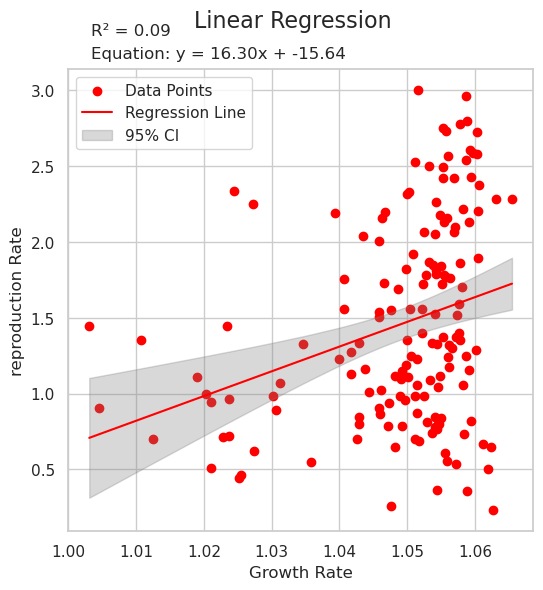

In [ ]:
# Create a single figure with two subplots
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Linear Regression', fontsize=16)

combined_df['growth_rate'] = np.exp(combined_df['growth_rate'])
# Define a function to plot the regression and confidence intervals
def plot_regression(ax, X, y, color, xlabel, ylabel):
    # Add a constant to the independent variable (for the intercept term)
    X_with_const = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X_with_const).fit()

    # Get the regression line
    y_pred = model.predict(X_with_const)

    # Sort X for a smooth plot
    sorted_X = np.sort(X)
    sorted_X_with_const = sm.add_constant(sorted_X)

    # Get the predicted values for the sorted X values
    sorted_y_pred = model.predict(sorted_X_with_const)

    # Plot the scatter plot and regression line
    ax.scatter(X, y, color=color, label='Data Points')
    ax.plot(sorted_X, sorted_y_pred, color='red', label='Regression Line')

    # Calculate R-squared
    r_squared = model.rsquared
    # Show the R² value on the left plot and the linear regression equation on the right plot
    ax.text(0.05, 1.1, f'R² = {r_squared:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(0.05, 1.05, f'Equation: y = {model.params[1]:.2f}x + {model.params[0]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Get the prediction intervals (95% CI) for sorted X values
    predictions = model.get_prediction(sorted_X_with_const)
    conf_int = predictions.conf_int(alpha=0.05)

    # Plot confidence intervals (shaded region)
    ax.fill_between(sorted_X, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3, label='95% CI')

    # Label the axes
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()

# Growth Rate vs Lifespan Plot (Position Text 'left' for R-squared)
plot_regression(axs, combined_df['growth_rate'], combined_df['reproduction_rate'], color='red', xlabel='Growth Rate', ylabel='reproduction Rate')

# Extra Functions

In [ ]:
def compare_random_worms(df, column, num_list=None, num_worms=3, rand=True):
    """
    Compare normal and smoothed growth measurements for a specified number of random worms.

    Parameters:
    df (pd.DataFrame): DataFrame containing growth measurements and smoothed values.
    growth_column (str): The column name for the normal growth measurements.
    num_worms (int): The number of random worms to compare.

    Returns:
    None: Displays a plot comparing the normal and smoothed values.
    """
    # Ensure the smoothed column exists
    smoothed_column = f'smoothed_{column}'
    if smoothed_column not in df.columns:
        raise ValueError(f"Column '{smoothed_column}' not found in DataFrame.")
    
    # Get unique Points (Worm IDs)
    worms = df['Point'].unique()

    
    if random: # Select random Points
        worm_list = random.sample(list(worms), num_worms)
    else:
        worm_list = []
    if num_list is not None:
        for worm in num_list:
            worm_list.append(worm)

    
    # Set up the plotting
    plt.figure(figsize=(12, 8))

    for point in worm_list:
        # Extract normal and smoothed values for the selected Point
        worm_data = df[df['Point'] == point]
        
        # Plot normal values
        plt.plot(worm_data['Time'], worm_data[column], label=f'Normal - Worm {point}', linestyle = 'solid', marker = None)
        # Plot smoothed values
        plt.plot(worm_data['Time'], worm_data[smoothed_column], label=f'Smoothed - Worm {point}', linestyle = '--', marker = None)

    # Adding plot details
    plt.title('Comparison of Normal and Smoothed Measurements')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.grid()
    plt.show()

def plot_all_histograms(df):
    # Select only numeric columns for plotting histograms
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Plot a histogram for each numeric column
    for column in numeric_columns:
        plt.figure(figsize=(8, 5))
        plt.hist(df[column].dropna(), bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

